In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
file_path = "/content/majorDataset.csv"
df = pd.read_csv(file_path)

# Drop unnecessary columns
df.drop(columns=['Date.Time', 'DOsat'], inplace=True, errors='ignore')

# Define features (X) and target (y)
X = df.drop(columns=['DO'])
y = df['DO']

# Split dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split training data into training and validation (80-20)
X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert to LightGBM dataset format
train_data = lgb.Dataset(X_train_sub, label=y_train_sub)
valid_data = lgb.Dataset(X_valid, label=y_valid)

# LightGBM parameters
# Update LightGBM parameters to use CPU instead of GPU
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9
}

# Train LightGBM on CPU
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[valid_data],
    valid_names=["Validation"],
    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(10)]
)


# Predictions
y_pred_lgb = lgb_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred_lgb)
mse = mean_squared_error(y_test, y_pred_lgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lgb)

# Print results
print(f"✅ LightGBM Model - MAE: {mae:.6f}, MSE: {mse:.6f}, RMSE: {rmse:.6f}, R² Score: {r2:.6f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 30266, number of used features: 4
[LightGBM] [Info] Start training from score 4.719699
Training until validation scores don't improve for 10 rounds
[10]	Validation's rmse: 2.00365
[20]	Validation's rmse: 1.41463
[30]	Validation's rmse: 1.08764
[40]	Validation's rmse: 0.910676
[50]	Validation's rmse: 0.814884
[60]	Validation's rmse: 0.762063
[70]	Validation's rmse: 0.728644
[80]	Validation's rmse: 0.703821
[90]	Validation's rmse: 0.686899
[100]	Validation's rmse: 0.672606
Did not meet early stopping. Best iteration is:
[100]	Validation's rmse: 0.672606
✅ LightGBM Model - MAE: 0.459172, MSE: 0.443171, RMSE: 0.665711, R² Score: 0.950801


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_style("whitegrid")

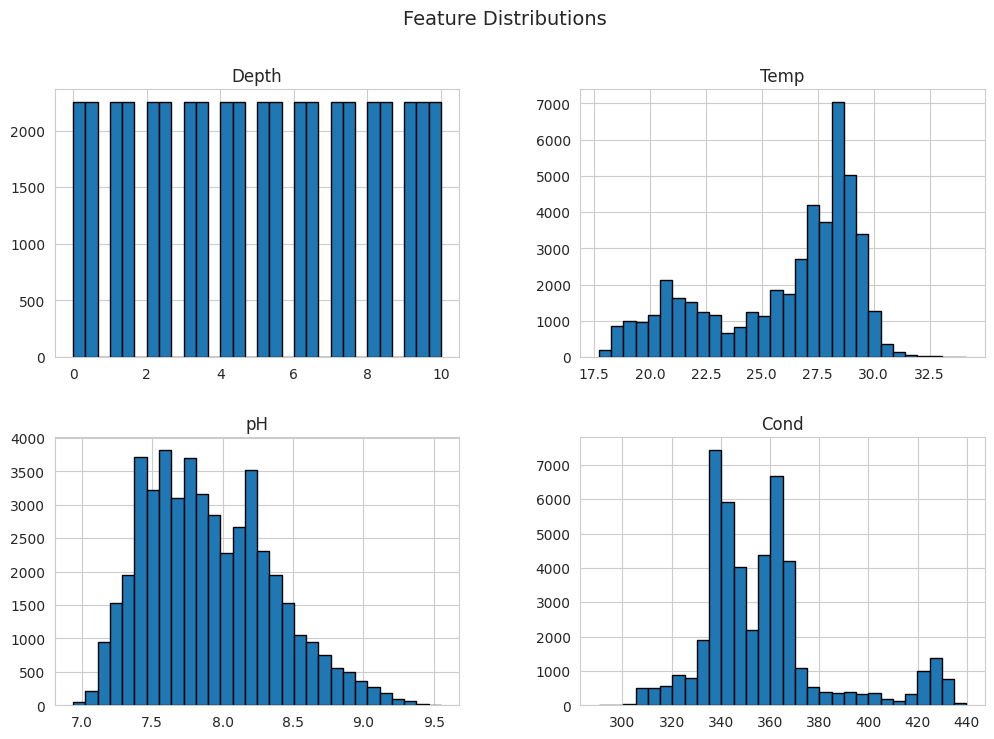

In [ ]:
# 📊 1. Histogram of Each Feature
X.hist(figsize=(12, 8), bins=30, edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

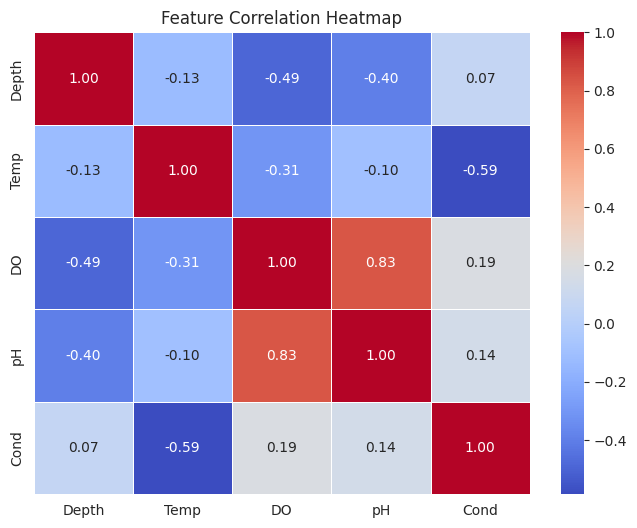

In [ ]:
# 📊 4. Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

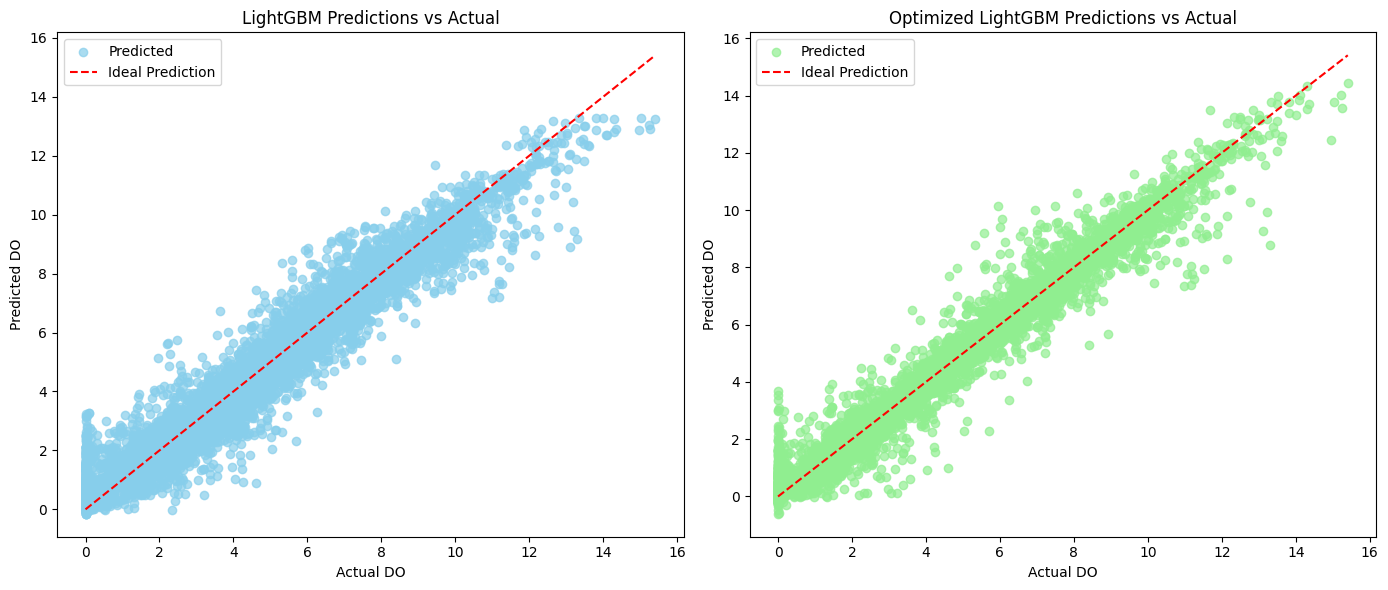

In [ ]:
import matplotlib.pyplot as plt



plt.figure(figsize=(14, 6))

# LightGBM Predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lgb, alpha=0.7, color='skyblue', label="Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Prediction")
plt.title("LightGBM Predictions vs Actual")
plt.xlabel("Actual DO")
plt.ylabel("Predicted DO")
plt.legend()
# Optimized Predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_final, alpha=0.7, color='lightgreen', label="Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Prediction")
plt.title("Optimized LightGBM Predictions vs Actual")
plt.xlabel("Actual DO")
plt.ylabel("Predicted DO")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import lightgbm as lgb
import numpy as np
from scipy.optimize import differential_evolution
from sklearn.model_selection import cross_val_score


def optimized_lgbm(params):

    num_leaves, max_depth, learning_rate, min_child_samples, subsample, colsample_bytree = (
        int(params[0]), int(params[1]), params[2], int(params[3]), params[4], params[5]
    )


    model = lgb.LGBMRegressor(
        objective="regression",
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_samples=min_child_samples,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        n_estimators=200,
        random_state=42,
        device_type="cpu"
    )


    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

    return -np.mean(scores)


bounds = [
    (10, 150),     # num_leaves
    (3, 20),       # max_depth
    (0.01, 0.3),   # learning_rate
    (10, 50),      # min_child_samples
    (0.5, 1.0),    # subsample
    (0.5, 1.0)     # colsample_bytree
]


result = differential_evolution(
    optimized_lgbm, bounds, strategy="best1bin", maxiter=10, popsize=15, tol=1e-5, mutation=(0.5, 1), recombination=0.7
)


optimized_params = result.x
num_leaves_opt, max_depth_opt, learning_rate_opt, min_child_samples_opt, subsample_opt, colsample_bytree_opt = (
    int(optimized_params[0]), int(optimized_params[1]), optimized_params[2],
    int(optimized_params[3]), optimized_params[4], optimized_params[5]
)


final_lgbm_model = lgb.LGBMRegressor(
    objective="regression",
    num_leaves=num_leaves_opt,
    max_depth=max_depth_opt,
    learning_rate=learning_rate_opt,
    min_child_samples=min_child_samples_opt,
    subsample=subsample_opt,
    colsample_bytree=colsample_bytree_opt,
    n_estimators=300,
    random_state=42,
    device_type="cpu"
)


final_lgbm_model.fit(X_train, y_train)
y_pred_final = final_lgbm_model.predict(X_test)


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_final = mean_absolute_error(y_test, y_pred_final)
mse_final = mean_squared_error(y_test, y_pred_final)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_test, y_pred_final)

print(f"✅ Optimized LightGBM Model - MAE: {mae_final:.6f}, MSE: {mse_final:.6f}, RMSE: {rmse_final:.6f}, R² Score: {r2_final:.6f}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
import joblib
joblib.dump(final_lgbm_model, "optimized_lgbm_model.pkl")
print("✅ Model saved as optimized_lgbm_model.pkl")

✅ Model saved as optimized_lgbm_model.pkl


In [ ]:
from google.colab import files
files.download("optimized_lgbm_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>